In [1]:
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics, set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier

set_config(display="diagram")


# Read Data

In [2]:
df = pd.read_csv(
    Path("data", "winequality-red-processed.csv",),
    index_col=0,
    dtype={
        "fixed_acidity": float,
        "volatile_acidity": float,
        "citric_acid": float,
        "chlorides": float,
        "free_sulfur_dioxide": float,
        "total_sulfur_dioxide": float,
        "density": float,
        "pH": float,
        "sulphates": float,
        "alcohol": float,
        "label": "category",
    },
)


df.head()


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0


# Split data
- Use `label` as target labels
    - Number of classes is $2$
    - **Classes are balanced**
    - Stratify labels when splitting so their distribution in train/test data is similar
- Split $75/25$ for training/testing
- Create empty dict to store all classifiers. Once populated, an item will look like:
`'classifier name' : {
    'pipeline': ...,
    'params': ...,
    'best_score': ...,
    'best_params': ...,
    'best_estimator': ...,
    'best_estimator_params': ...,
    'testing_accuracy': ...,
    'testing_conf_matrix': ...,
}`

In [3]:
y = df["label"]
num_class = len(y.unique())

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

joblib.dump(
    le, Path("models", "le.pkl",),
)

X = df.drop(["label"], axis=1)
num_features = X.columns.tolist()

if not Path("models").is_dir():
    Path("models").mkdir()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.75, shuffle=True, stratify=y, random_state=42,
)

classifiers = dict()


# Transformers
1. A pipeline for numerical features: `num`. This will have 2 step:
    - `KNNImputer` to fill-in missing values with the mean of neighboring samples (in case we have missing data in the future)
    - `RobustScaler` to scale features using statistics that are robust to outliers

- `remainder=drop` will be used to drop any extra features that might be added to the dataframe later as a safety guard. When adding new features, either pass them through a pipeline, or change to `remainder=passthrough`

In [4]:
transformer = Pipeline(
    steps=[("imputer", KNNImputer(n_neighbors=5)), ("scaler", RobustScaler()),]
)

preprocessor = ColumnTransformer(
    transformers=[("num", transformer, num_features)], remainder="drop",
)


# Classifiers

## Decision Tree

- Can be interpreted as a piecewise constand approximation
- Learns the value of target variable through decision rules generated from the features in the dataset
- Advantages
    - Requires little data and cost to use
    - Suited for numerical and categorical data and able to handle multi-output
- Disadvantages
    - Can easily overfit data
    - Can create biased trees
    - Can be unstable

In [5]:
classifier = DecisionTreeClassifier(random_state=42,)

pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier),])

params = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": [5, 6, 7],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__splitter": ["best", "random"],
}

classifiers["DecisionTreeClassifier"] = {
    "pipeline": pipeline,
    "params": params,
}


## Random Forest Ensemble

- Each tree is trained on a random subset of the training set with replacement (i.e. bootstrap aggregating or bagging)
- Each tree is trained on a random subset of features, the number of features to use is defined by `max_features`
- Advantages
    - No need for scaling
    - No need for dimensionality reduction (unless rotation is needed)
- Disadvantages
    - Sensitive to small variations in the training data
    - Over-fitting
    - Difficult to interpret

In [6]:
classifier = RandomForestClassifier(
    bootstrap=True, oob_score=True, random_state=42, n_jobs=-1,
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier),])

params = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__n_estimators": [200, 300, 400],
    "classifier__max_depth": [8, 9, 10],
    "classifier__max_features": ["sqrt", "log2"],
}

classifiers["RandomForestClassifier"] = {
    "pipeline": pipeline,
    "params": params,
}


## Adaptive Boosting
- AdaBoost uses decision tress with a single split and puts more weight on datapoints which are harder to classify and less on those handeled well
- By default uses 'SAAME.R' algorithm which converges faster than SAMME and outputs class probabilites
- Advantages
    - Flexible as can be used to improve weak classifiers
- Disadvantages
    - Data needs to be of high quality
    - Sensitive to Noisy data and outliers
    - Slow

In [7]:
classifier = AdaBoostClassifier(random_state=42,)

pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier),])

params = {
    "classifier__algorithm": ["SAMME", "SAMME.R"],
    "classifier__n_estimators": [200, 300, 400],
    "classifier__learning_rate": [0.01, 0.1, 1],
}

classifiers["AdaBoostClassifier"] = {
    "pipeline": pipeline,
    "params": params,
}


# Training

## Grid search cross validation

- Use `accuracy` for scoring as binary classification
- Loop over each classifier in the classifiers dictionary
    - Train using training data
    - Pickle trained model

In [8]:
for k, v in classifiers.items():

    print(f"\nRunning grid search with cross validation for {k}...")

    gs = GridSearchCV(
        v["pipeline"], v["params"], scoring="accuracy", cv=5, n_jobs=-1, verbose=2,
    )

    gs.fit(
        X_train, y_train,
    )

    joblib.dump(
        gs, Path("models", f"{k}.pkl",),
    )



Running grid search with cross validation for DecisionTreeClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Running grid search with cross validation for RandomForestClassifier...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   13.4s finished



Running grid search with cross validation for AdaBoostClassifier...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.9s finished


# Validation

- Loop over each classifier in the classifiers dictionary
    - Load model
        - Store the grid search `best_score_`
        - Store the grid search `best_params_`
        - Store the grid search `best_estimator_`
        - Store the grid search `best_estimator_` params
    - Evalute using testing data
        - Store the `accuracy_score`
        - Store class-wise

In [9]:
for k, v in classifiers.items():

    gs = joblib.load(Path("models", f"{k}.pkl",),)

    v["best_score"] = gs.best_score_
    v["best_params"] = gs.best_params_
    v["best_estimator"] = gs.best_estimator_
    v["best_estimator_params"] = gs.best_estimator_.named_steps[
        "classifier"
    ].get_params()

    print(f"Running evaluation on test data for {k}...")
    y_pred = gs.predict(X_test)

    v["testing_accuracy"] = accuracy_score(y_test, y_pred,)

    v["testing_conf_matrix"] = confusion_matrix(y_test, y_pred,)


Running evaluation on test data for DecisionTreeClassifier...
Running evaluation on test data for RandomForestClassifier...
Running evaluation on test data for AdaBoostClassifier...


- Create DataFrame of results from all classifiers and save into cvs
- Load LinearSVC and get features importance using the models `coef_` 
- Get features importance for RandomForestClassifier

In [10]:
pd.DataFrame.from_dict(classifiers, orient="index",).to_csv(
    Path("models", "models.csv",)
)


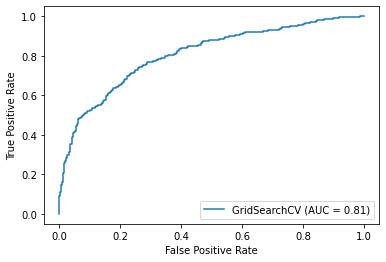

RForest Feature_importances:
(0.20836218199904458, 'alcohol')
(0.11679157751675216, 'volatile_acidity')
(0.09991442156298916, 'sulphates')
(0.09165355154538163, 'total_sulfur_dioxide')
(0.08550635296641287, 'chlorides')
(0.08375929527288786, 'density')
(0.08026933828755757, 'pH')
(0.06063722613349877, 'free_sulfur_dioxide')
(0.05975488674989047, 'fixed_acidity')
(0.059287563194616984, 'citric_acid')
(0.054063604770967985, 'residual_sugar')


In [11]:
gs = joblib.load(Path("models", "RandomForestClassifier.pkl",))

metrics.plot_roc_curve(gs, X_test, y_test)
plt.show()

importance = gs.best_estimator_.named_steps["classifier"].feature_importances_
features_importance = sorted(zip(importance, num_features), reverse=True)
print("RForest Feature_importances:", *features_importance, sep="\n")


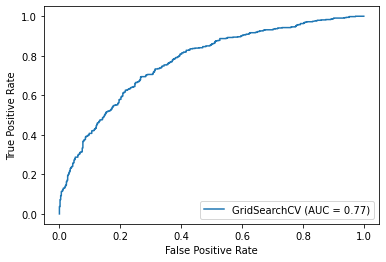

AdaBoost Feature_importances:
(0.21009198191085166, 'alcohol')
(0.17510701410252633, 'volatile_acidity')
(0.10066668871987386, 'sulphates')
(0.09252500384844661, 'total_sulfur_dioxide')
(0.08909285262826123, 'density')
(0.07932149352990117, 'fixed_acidity')
(0.0748950688204901, 'residual_sugar')
(0.05964763414702707, 'pH')
(0.05522000132387234, 'chlorides')
(0.05272748293301545, 'free_sulfur_dioxide')
(0.010704778035733999, 'citric_acid')


In [12]:
gs = joblib.load(Path("models", "AdaBoostClassifier.pkl",))

metrics.plot_roc_curve(gs, X_test, y_test)
plt.show()


importance = gs.best_estimator_.named_steps["classifier"].feature_importances_
features_importance = sorted(zip(importance, num_features), reverse=True)
print("AdaBoost Feature_importances:", *features_importance, sep="\n")


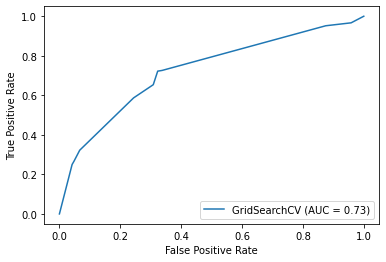

Decision Tree Feature_importances:
(0.7046089597353706, 'alcohol')
(0.1274021210122045, 'volatile_acidity')
(0.04588857344062408, 'residual_sugar')
(0.042785045990734766, 'chlorides')
(0.028420942100052308, 'free_sulfur_dioxide')
(0.023737103364284005, 'citric_acid')
(0.01975888997342807, 'total_sulfur_dioxide')
(0.005628911549860419, 'density')
(0.0017694528334413306, 'sulphates')
(0.0, 'pH')
(0.0, 'fixed_acidity')


In [13]:
gs = joblib.load(Path("models", "DecisionTreeClassifier.pkl",))

metrics.plot_roc_curve(gs, X_test, y_test)
plt.show()

importance = gs.best_estimator_.named_steps["classifier"].feature_importances_
features_importance = sorted(zip(importance, num_features), reverse=True)
print("Decision Tree Feature_importances:", *features_importance, sep="\n")

